In [1]:
import os

import numpy as np

In [2]:
def load_embedding(folder, model) -> list[np.ndarray]:
    if model == "birdnet":
        # in this case the embedding is a text file for each audio
        # the file is start_time \t end_time \t embedding \n
        # embedding is comma separated float values
        # frames are 3s long (possibly configurable)
        embeddings = []
        for filename in sorted(os.listdir(folder)):
            with open(os.path.join(folder, filename), "r") as f:
                lines = f.readlines()
            # first two els are start and end time
            embedding = np.array([list(map(float, line.split("\t")[2].split(","))) for line in lines])
            embeddings.append(embedding)
        return embeddings
    if model == "yamnet":
        # in this case the embedding is a numpy array 
        # (n_audios=64, max_n_frames=148, embedding_dim=1024)
        # the padding value is 0, the frames are every 0.48 (probably)
        filename = os.listdir(folder)[0]
        embedding = np.load(os.path.join(folder, filename))
        return [emb for emb in embedding]
    if model == "perch":
        pass
    else:
        raise ValueError(f"Unknown pretrained model {model}")

In [3]:
l1 = load_embedding("data/embeddings/yamnet/granollers", "yamnet")
len(l1), l1[0].shape

(64, (148, 1024))

In [4]:
l2 = load_embedding("data/embeddings/birdnet/granollers", "birdnet")
len(l2), l2[0].shape

(64, (8, 1024))

In [5]:
embeddings_folder = "data/embeddings"

emebddings_models = ["birdnet", "yamnet"] #, "perch"]
datasets = ["granollers", "sabadell", "sons_al_balco_2020", "sons_al_balco_2021"]

embeddings = {}
for model in emebddings_models:
    for dataset in datasets:
        folder = os.path.join(embeddings_folder, model, dataset)
        embedding = load_embedding(folder, model)
        embeddings[(model, dataset)] = embedding

In [6]:
embeddings.keys()

dict_keys([('birdnet', 'granollers'), ('birdnet', 'sabadell'), ('birdnet', 'sons_al_balco_2020'), ('birdnet', 'sons_al_balco_2021'), ('yamnet', 'granollers'), ('yamnet', 'sabadell'), ('yamnet', 'sons_al_balco_2020'), ('yamnet', 'sons_al_balco_2021')])

In [7]:
from utils import create_frame_labels

labels_2020 = create_frame_labels(labels_filename=os.path.join("data", "sons_al_balco_labels", "SAB-AudioTagging-2020.json"))   
labels_2021 = create_frame_labels(labels_filename=os.path.join("data", "sons_al_balco_labels", "SAB-AudioTagging-2021.json"))
# dictionaries {filename: {n_frame: list of labels}}

labels_2020

2024-02-23 15:07:40.297864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 15:07:42.233026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 15:07:42.243199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 15:07:56.145934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


{'fu_acj5fhi5thvu5hb.wav': {0: ['Things/Trolley'],
  1: ['Things/Trolley'],
  2: ['Things/Trolley'],
  3: ['Things/Trolley'],
  4: ['Things/Trolley'],
  5: ['Things/Trolley'],
  6: ['Things/Trolley'],
  7: ['Things/Trolley'],
  8: ['Things/Trolley'],
  9: ['Things/Trolley'],
  10: ['Things/Trolley'],
  11: ['Things/Trolley'],
  12: ['Things/Trolley'],
  13: ['Things/Trolley'],
  14: ['Things/Trolley'],
  15: ['Things/Trolley'],
  16: ['Things/Trolley'],
  17: ['Things/Trolley'],
  18: ['Things/Trolley'],
  19: ['Things/Trolley'],
  20: ['Things/Trolley'],
  21: ['Things/Trolley'],
  22: ['Things/Trolley'],
  23: ['Things/Trolley']},
 'fu_9qqub3qmettq344.wav': {61: ['Nature/Elements/Wind'],
  62: ['Nature/Elements/Wind'],
  63: ['Nature/Elements/Wind'],
  64: ['Nature/Elements/Wind'],
  55: ['Nature/Elements/Wind'],
  56: ['Nature/Elements/Wind'],
  57: ['Nature/Elements/Wind'],
  58: ['Nature/Elements/Wind'],
  44: ['Nature/Elements/Wind'],
  45: ['Nature/Elements/Wind'],
  46: ['Natur

Let's select only the frames with a label

In [8]:
lab_values = []
for l_dict in labels_2020.values():
  for el in l_dict.values():
    lab_values.extend(el)
for l_dict in labels_2021.values():
  for el in l_dict.values():
    lab_values.extend(el)

lab_values = list(set(lab_values))  # list is to have idxs
len(lab_values)

29

In [9]:
data_20 = []
lab_20_arr = []
for e, (filename, l_dict) in zip(embeddings[("yamnet", "sons_al_balco_2020")], sorted(labels_2020.items())):
  idx = sorted([frame_n for frame_n, l in l_dict.items() if len(l) > 0])
  for i in idx:
    for l in l_dict[i]:
      data_20.append(e[i])
      lab_20_arr.append(lab_values.index(l))

data_20 = np.stack(data_20, axis=0)
lab_20_arr = np.array(lab_20_arr)
data_20.shape, lab_20_arr.shape

((3642, 1024), (3642,))

In [10]:
data_21 = []
lab_21_arr = []
for e, (filename, l_dict) in zip(embeddings[("yamnet", "sons_al_balco_2021")], sorted(labels_2021.items())):
  idx = sorted([frame_n for frame_n, l in l_dict.items() if len(l) > 0])
  for i in idx:
    for l in l_dict[i]:
      data_21.append(e[i])
      lab_21_arr.append(lab_values.index(l))

data_21 = np.stack(data_21, axis=0)
lab_21_arr = np.array(lab_21_arr)
data_21.shape, lab_21_arr.shape

((6093, 1024), (6093,))

Let's plot different embeddings (with different dimensionality reduction methods)

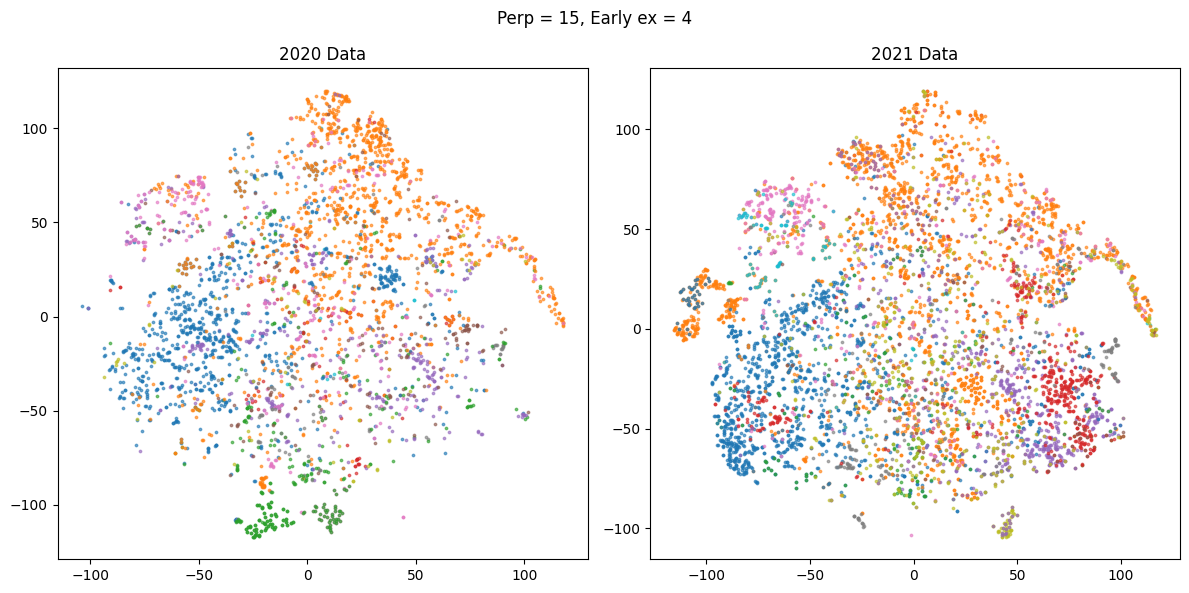

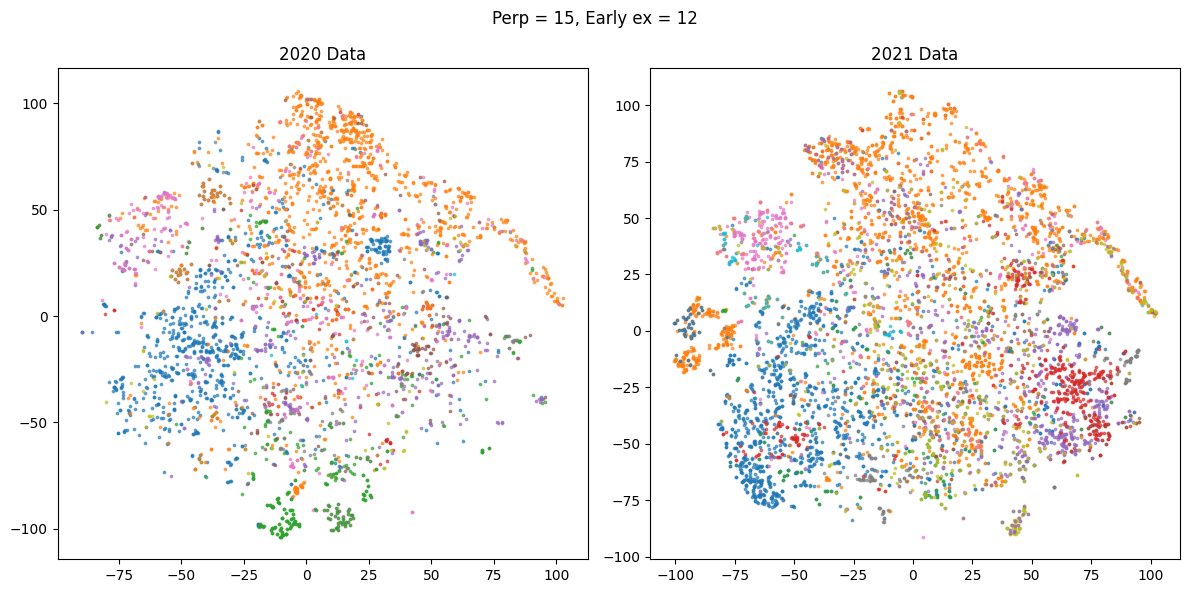

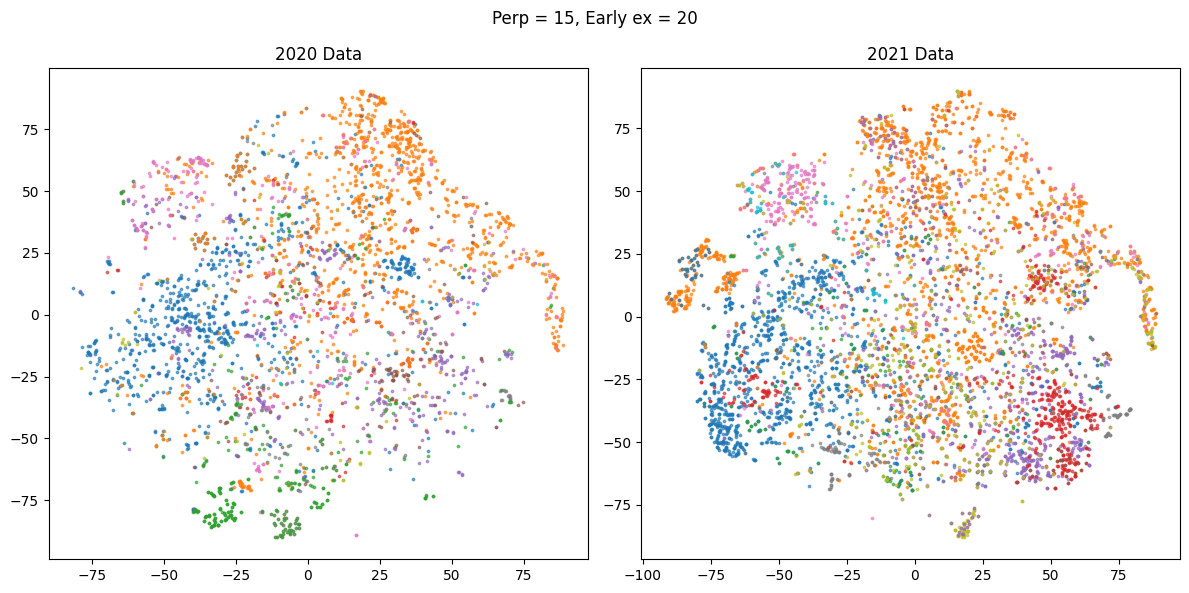

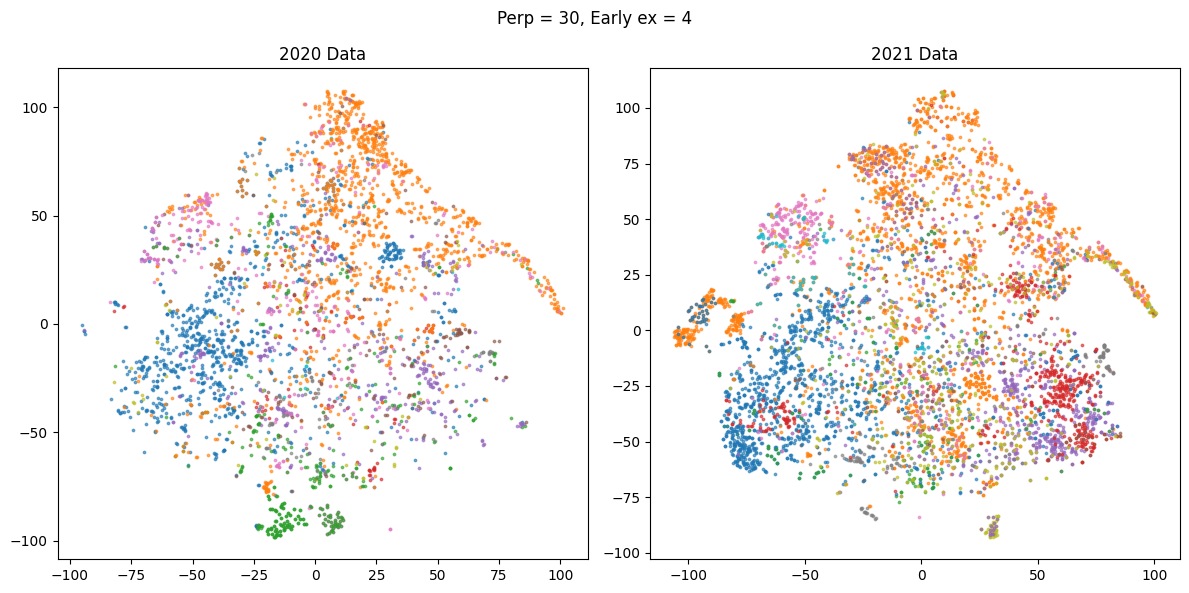

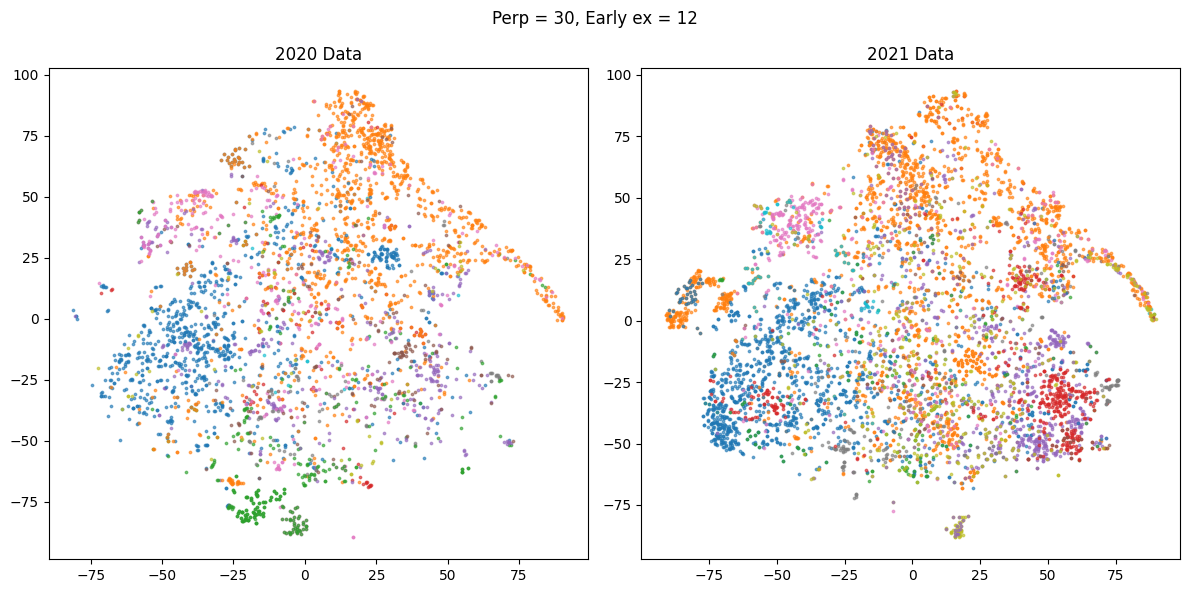

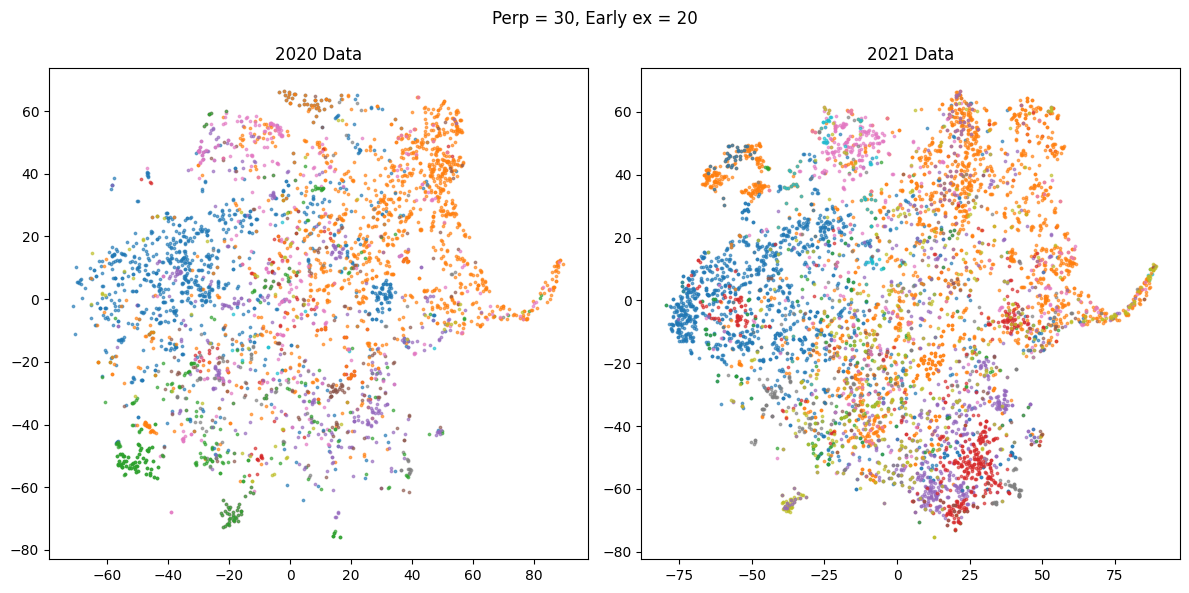

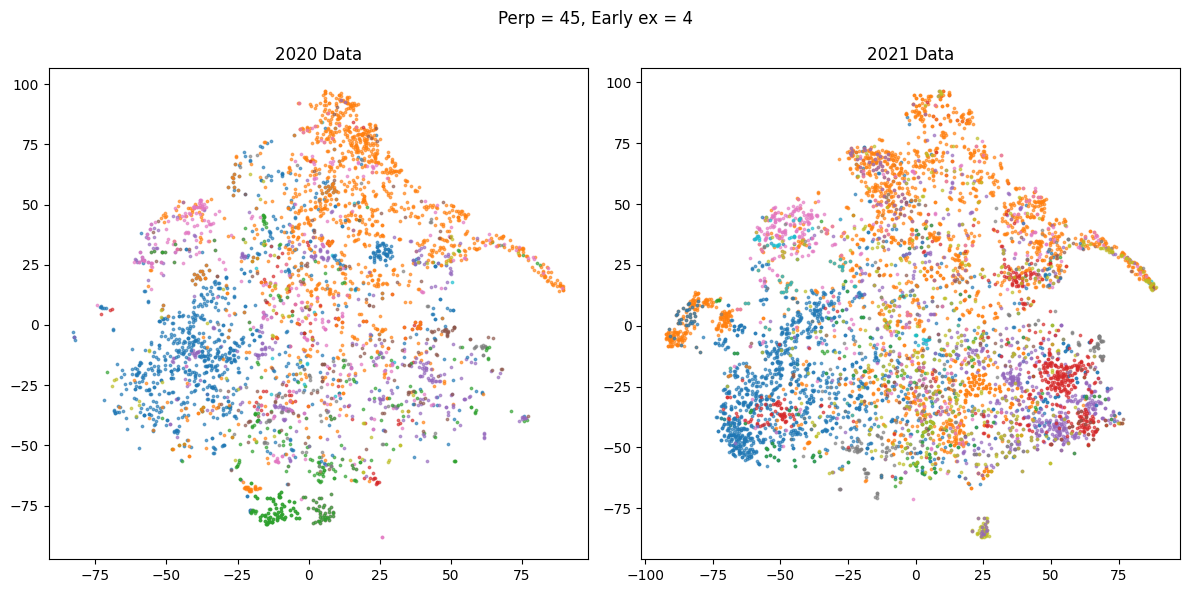

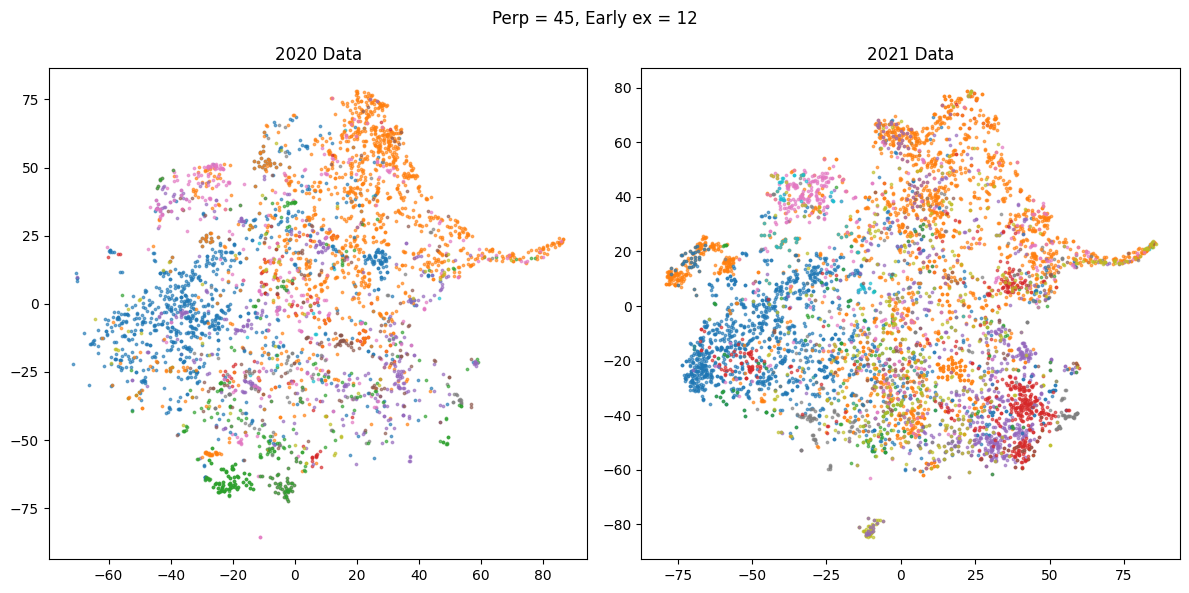

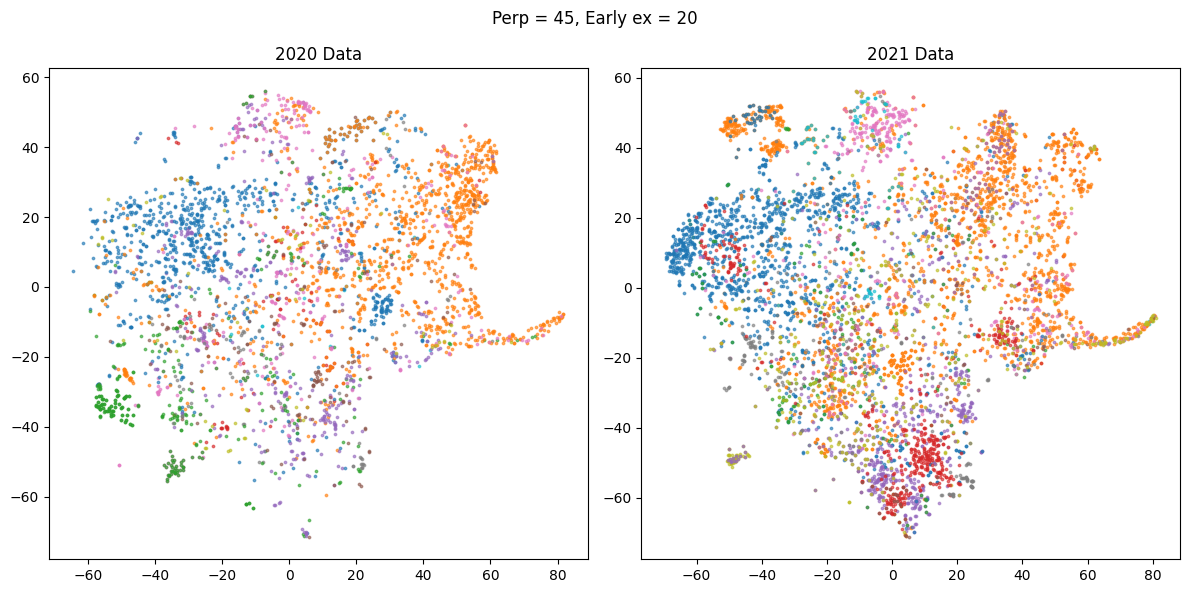

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

S = 3       # size of the points
ALPHA = 0.6 # transparency

# for tsne, first reduce n_dimension to 50 using PCA (suggested by sklearn)
n_2020 = data_20.shape[0]
data = np.concatenate([data_20, data_21])

pca = PCA(n_components=50)
pca_emb = pca.fit_transform(data)

# default
# tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0)

perplexity = [15, 30, 45]
early_exaggeration = [4, 12, 20]

for p in perplexity:
  for ea in early_exaggeration:
    tsne = TSNE(n_components=2, perplexity=p, early_exaggeration=ea)

    bidim_data = tsne.fit_transform(pca_emb)
    bidim_sob_2020 = bidim_data[:n_2020, :]
    bidim_sob_2021 = bidim_data[n_2020:, :]

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plots
    for i, lab in enumerate(lab_values):
      # Plot for 2021
      idx = lab_20_arr == i 
      axs[0].scatter(x=bidim_sob_2020[idx][:, 0], y=bidim_sob_2020[idx][:, 1], color=f'C{i}', label=lab, s=S, alpha=ALPHA)
      axs[0].set_title("2020 Data")

      # Plot for 2021
      idx = lab_21_arr == i
      axs[1].scatter(x=bidim_sob_2021[idx][:, 0], y=bidim_sob_2021[idx][:, 1], color=f'C{i}', label=lab, s=S, alpha=ALPHA)
      axs[1].set_title("2021 Data")

    # Overall title for the subplot
    plt.suptitle(f"Perp = {p}, Early ex = {ea}")
    # legend
    #plt.legend()
    # Adjust layout to prevent overlap of titles
    plt.tight_layout()
    # Show plot
    plt.show()

In [12]:

n_neighbors = [5, 15, 50] 
min_dist = [0.0, 0.1, 0.9]

for nn in n_neighbors:
  for md in min_dist:
    reducer = umap.UMAP(n_neighbors=nn, min_dist=md)
    bidim_data = reducer.fit_transform(pca_emb)
    bidim_sob_2020 = bidim_data[:n_2020, :]
    bidim_sob_2021 = bidim_data[n_2020:, :]

    # Create figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plots
    for i, lab in enumerate(lab_values):
      # Plot for 2021
      idx = lab_20_arr == i 
      axs[0].scatter(x=bidim_sob_2020[idx][:, 0], y=bidim_sob_2020[idx][:, 1], color=f'C{i}', label=lab, s=S, alpha=ALPHA)
      axs[0].set_title("2020 Data")

      # Plot for 2021
      idx = lab_21_arr == i
      axs[1].scatter(x=bidim_sob_2021[idx][:, 0], y=bidim_sob_2021[idx][:, 1], color=f'C{i}', label=lab, s=S, alpha=ALPHA)
      axs[1].set_title("2021 Data")

    # Overall title for the subplot
    plt.suptitle(f"N neigh = {nn}, Min dist = {md}")
    # legend
    #plt.legend()
    # Adjust layout to prevent overlap of titles
    plt.tight_layout()
    # Show plot
    plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'